In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

Loading dataset:

In [ ]:
df = pd.read_csv('/content/amazon_reviews_us_Watches_v1_00.tsv',
                 sep='\t', on_bad_lines='skip')
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,3653882,R3O9SGZBVQBV76,B00FALQ1ZC,937001370,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold ...",Watches,5,0,0,N,Y,Five Stars,Absolutely love this watch! Get compliments al...,2015-08-31
1,US,14661224,RKH8BNC3L5DLF,B00D3RGO20,484010722,Kenneth Cole New York Women's KC4944 Automatic...,Watches,5,0,0,N,Y,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,2015-08-31
2,US,27324930,R2HLE8WKZSU3NL,B00DKYC7TK,361166390,Ritche 22mm Black Stainless Steel Bracelet Wat...,Watches,2,1,1,N,Y,Two Stars,Scratches,2015-08-31
3,US,7211452,R31U3UH5AZ42LL,B000EQS1JW,958035625,Citizen Men's BM8180-03E Eco-Drive Stainless S...,Watches,5,0,0,N,Y,Five Stars,"It works well on me. However, I found cheaper ...",2015-08-31
4,US,12733322,R2SV659OUJ945Y,B00A6GFD7S,765328221,Orient ER27009B Men's Symphony Automatic Stain...,Watches,4,0,0,N,Y,"Beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...,2015-08-31


Convert to bin target column for binary classification:

In [ ]:
def convert_to_bin(target):
  bin_target = list()

  for i in range(len(target)):
    if target.iloc[i] >= 3:
      bin_target.append(1)
    else:
      bin_target.append(-1)

  return bin_target

Extracting a relevant column for prediction and using **convert_to_bin** function for **star_rating** column:

In [ ]:
X = df['review_body']
y = convert_to_bin(df['star_rating'])

Splitting data on train and test sets:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    random_state=42,
    test_size=0.2,
    stratify=y
)

Using **SimpleImputer** for cleaning input data by filling **None** rows:

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

clean_train = imputer.fit_transform(np.array(X_train).reshape(-1, 1))
clean_test = imputer.transform(np.array(X_test).reshape(-1, 1))

Creating **TfidfVectorizer**, **SVC** and **GridSearchCV** estimators:

In [ ]:
vectorizer = TfidfVectorizer()

svc = SVC(class_weight='balanced')

params= {
    'C': [0.1, 1, 1.5, 5, 10],
    'gamma': [1.5, 1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'sigmoid']
}

clf = GridSearchCV(svc, params, n_jobs=-1, cv=5)

Creating **Pipeline** includes **TfidfVectorizer** and **GridSearchCV** instances and computing its fitting speed:

In [ ]:
pipe = Pipeline([('vect', vectorizer), ('clf', clf)])

train_batch = int(input('Print batch size(recommended 1000): '))

start_fit = time.time()
pipe.fit(clean_train.reshape(1, -1)[0,:train_batch], y_train[:train_batch])
end_fit = time.time()

print("Fitting time = {:.3f} seconds".format(end_fit - start_fit))

Print batch size(recommended 1000): 1000
Fitting time = 75.984 seconds


Visualization cross-validation results:

In [ ]:
clf.cv_results_

{'mean_fit_time': array([0.18319173, 0.17569361, 0.17693114, 0.1785975 , 0.17138824,
        0.17861581, 0.18600931, 0.18289528, 0.19211392, 0.19679604,
        0.27941952, 0.31694617, 0.29376936, 0.2536757 , 0.33028789,
        0.3171783 , 0.14543347, 0.13860564, 0.18284931, 0.26753006,
        0.30600901, 0.31909132, 0.23562212, 0.26559777, 0.33126636,
        0.24180293, 0.28531327, 0.22360406, 0.13642573, 0.22747855,
        0.27016129, 0.19123969, 0.21350608, 0.29086576, 0.20382757,
        0.21742821, 0.29754057, 0.20962944, 0.17259197, 0.18573709,
        0.12569427, 0.18413725, 0.18866091, 0.11381202, 0.19172416,
        0.18463712, 0.10912633, 0.10009155, 0.18282313, 0.11126418,
        0.10296803, 0.13594618, 0.11318259, 0.15106053, 0.18594956,
        0.11640873, 0.20090823, 0.17318339, 0.11592836, 0.26246157,
        0.29626145, 0.19814367, 0.25392056, 0.44241009, 0.37399263,
        0.1563767 , 0.16868978, 0.11727066, 0.14619431, 0.16594796,
        0.1068336 , 0.17845263,

In [ ]:
clf.best_params_

{'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}

In [ ]:
clf.best_score_

0.891

In [ ]:
clf.best_estimator_

SVC(C=5, class_weight='balanced', gamma=0.1)

Computing model's predictions and evaluating prediction time:

In [ ]:
test_size = X_test.shape[0] / X_train.shape[0]
test_batch = int(train_batch * test_size)

start_pred = time.time()
pred = pipe.predict(clean_test.reshape(1, -1)[0,:test_batch])
end_pred = time.time()

print("Predicting time = {:.3f}".format(end_pred - start_pred))

Predicting time = 0.073


Evaluating model predictions:

In [ ]:
print(classification_report(y_test[:test_batch], pred, labels=(1,-1)))

              precision    recall  f1-score   support

           1       0.94      0.94      0.94       217
          -1       0.62      0.61      0.62        33

    accuracy                           0.90       250
   macro avg       0.78      0.78      0.78       250
weighted avg       0.90      0.90      0.90       250



## Visualization ROC Curve

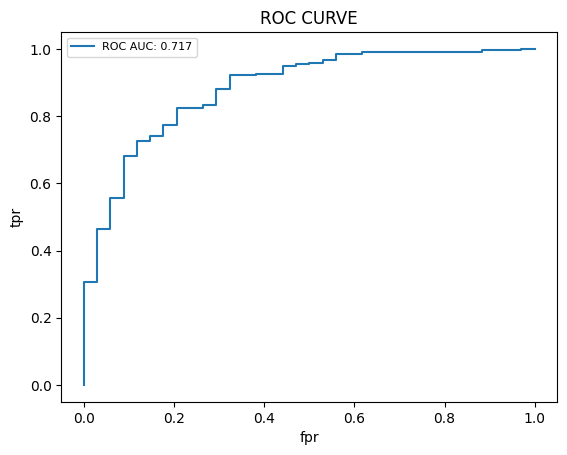

In [ ]:
decision = pipe.decision_function(clean_test.reshape(1, -1)[0,:test_batch])
fpr, tpr, thresholds = roc_curve(y_test[:test_batch], decision, pos_label=1)
roc_auc = roc_auc_score(y_test[:test_batch], pred)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, label='ROC AUC: {:.3f}'.format(roc_auc))
ax.set_title('ROC CURVE')
ax.set_xlabel('fpr')
ax.set_ylabel('tpr')
ax.legend(fontsize=8)
plt.show()